# Harmonic Oscillator

Following section 12.3.3 in the book, we try to solve 3-dimensional quantum harmonic ossilator using diffusion Monte Carlo and a guide function. The guide wave function is:
$$\psi(r) = \exp{-\alpha r^2}$$
Where $r=|\mathbf{r}|$.
The algorithm is stated on page 389.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import cProfile

In [15]:
def plot_position(pos_vector,alive):
    """Returns 3D plot of the walker positions"""
    k = 0
    x = np.zeros((alive.count(True),3))
    
    for i in range(np.shape(pos_vector)[0]):
        if alive[i]:
            x[k,:] = pos_vector[i,:]
            k +=1
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2])
    L=3
    ax.set_xlim3d([-L,L])
    ax.set_ylim3d([-L,L])
    ax.set_zlim3d([-L,L])

In [16]:
Nsteps = 1000                         #Number of walker steps
N = 1000                              #Targeted number of random walkers
Nbuffer = np.trunc(N*1.5).astype(int) #Some extra walkers so that it is possible to create new walkers

x_init_3D = np.random.uniform(-1, 1, (Nbuffer,3)) #Unif. Initial position Random Walker
step_equi = 200                       #Steps needed to reach equilibrium positions

dt = 0.05                             #Variable in DMC method

#Inialize some random arrays, which we can use later
rand_matrix1 = np.random.uniform(size = (Nbuffer, Nsteps)) #To create or to anniliate
rand_matrix2 = np.random.normal(scale = np.sqrt(dt), size = (Nbuffer, 3, Nsteps))  #To give stepsize, equations 12.33 and 12.23


i is  0  out of  1000
E =  1.52187767946


C:\Users\Bas\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


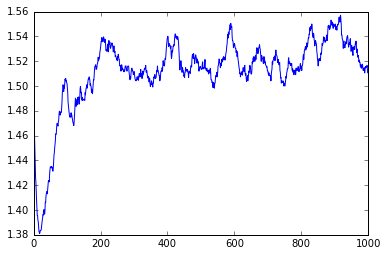

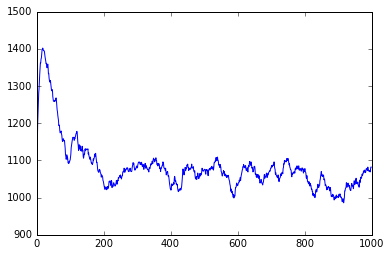

In [17]:
Pos_walkers = np.array(x_init_3D)
#Inital guess for energy
ET = 3/2+.05
E0 = 3/2+.05

#Initalize alive array
alive = [False for i in range(Nbuffer)]
for i in range(N):
    alive[i] = True

alpha = 0.5

Energy = np.zeros((Nsteps,1))
Nprime = np.zeros((Nsteps,1))

for i in range(Nsteps):
    for j in range(N):
        if alive[j]:
            Pos_walkers[j,:] += rand_matrix2[j,:,i]
            q = np.exp(-dt*(.5*np.sum(Pos_walkers[j,:]*Pos_walkers[j,:])-ET))
            s = np.trunc(q+rand_matrix1[j,i]).astype(int)
            #this is where we play God
            if s == 0:
                #delete walkers
                alive[j]=False            
            else: 
                #create walkers
                for k in range(s-1):
                    #only if there are dead walkers
                    if False in alive:
                        reswalker = alive.index(False)
                        alive[reswalker] = True
                        Pos_walkers[reswalker,:] = Pos_walkers[j,:]
    Nprime[i] = alive.count(True)
    ET = E0 + alpha * np.log( N / Nprime[i] )
    Energy[i] = ET
    if i % 1000 == 0:
        print('i is ',i,' out of ',Nsteps)

plt.figure(1)
plt.plot(Energy)
plt.figure(2)
plt.plot(Nprime)

print('E = ',np.mean(Energy[step_equi::]))

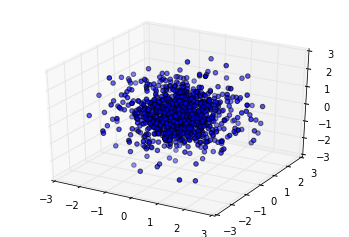

In [18]:
plot_position(Pos_walkers,alive)

# Harmonic oscillator with guidance function

In [19]:
Nsteps = 1000                            #Number of walker steps
N = 1000                                 #Targeted number of random walkers
Nbuffer = np.trunc(N*1.5).astype(int)    ##Some extra walkers so that it is possible to create new w

#Parameter in wavefunction, a=.5 is exact solution
a=.4

x_init_3D = np.random.uniform(-1, 1, (Nbuffer,3)) #Unif. Initial position Random Walker
step_equi = 500                          #Steps to reach equilibrium positions

dt = 0.05                                #Parameter in DMC method

#Inialize some random arrays, which we can use later
rand_matrix1 = np.random.uniform(size = (Nbuffer, Nsteps)) #To create or to anniliate
rand_matrix2 = np.random.normal(scale = np.sqrt(dt), size = (Nbuffer, 3, Nsteps))  #To give stepsize, equations 12.33 and 12.23
rand_matrix3 = np.random.uniform(size = (Nbuffer, Nsteps)) #To step or not to step 

i is  0  out of  1000
i is  100  out of  1000
i is  200  out of  1000
i is  300  out of  1000
i is  400  out of  1000
i is  500  out of  1000
i is  600  out of  1000
i is  700  out of  1000
i is  800  out of  1000
i is  900  out of  1000
E =  1.50099824696
varE =  0.000151488049638


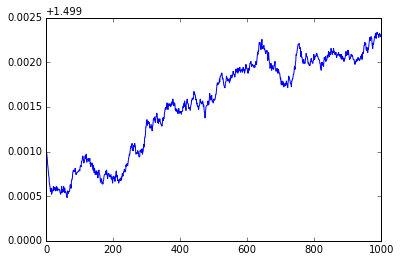

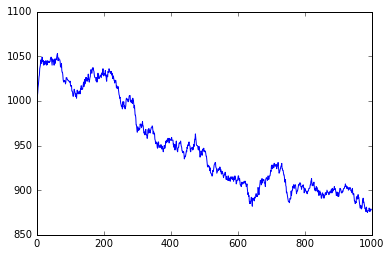

In [20]:
Pos_walkers = np.array(x_init_3D)

#Inital guess ground state energy
ET = 3/2
E0 = 3/2

#Initalize alive array
alive = [False for i in range(Nbuffer)]
for i in range(N):
    alive[i] = True

alpha = 0.01

Energy = np.zeros((Nsteps,))
Nprime = np.zeros((Nsteps,))
F = np.zeros((3,))
V = np.zeros((1,))
R = np.zeros((3,))
Fprime = np.zeros((3,))
Vprime = np.zeros((1,))
Rprime = np.zeros((3,))

for i in range(Nsteps):
    for j in range(N):
        if alive[j]:
            #Calculate force and local energy bassed on current position
            F = - 4 * a * Pos_walkers[j,:]
            V = 3 * a + (.5 - 2 * a**2) * np.sum(Pos_walkers[j,:] * Pos_walkers[j,:]) 
            #Temporarly save previous position
            R = Pos_walkers[j,:]
            
            #Add random displacement and THE FORCE
            Rprime = R + rand_matrix2[j,:,i] + F * dt / 2
            #Calculate force and local energy bassed on new position
            Vprime = 3 * a + (.5 - 2 * a**2) * np.sum(Pos_walkers[j,:] * Pos_walkers[j,:]) 
            Fprime = - 4 * a * Pos_walkers[j,:]
            
            #accept or decline step, using equation 12.61
            accept = np.exp(- 1/(2*dt)*np.linalg.norm(R - Rprime - Fprime*dt/2)**2 \
                            + 1/(2*dt)*np.linalg.norm(Rprime -R - F*dt/2)**2 \
                            + 2 * a *(np.sum(R*R)-np.sum(Rprime*Rprime) ))
            if accept >= rand_matrix3[j,i]:
                Pos_walkers[j,:] = Rprime
                q = np.exp(- dt * ((Vprime + V)/2 - ET))
                t = np.trunc(q+rand_matrix1[j,i]).astype(int)
                #this is where we play God
                if t == 0:
                    #Delete walker
                    alive[j]=False            
                else: 
                    #Create walker(s)
                    for k in range(t-1):
                        #only if there are dead walkers
                        if False in alive:
                            reswalker = alive.index(False)
                            alive[reswalker] = True
                            Pos_walkers[reswalker,:] = Pos_walkers[j,:]
    Nprime[i] = alive.count(True)
    ET = E0 + alpha * np.log( N / Nprime[i] )
    Energy[i] = ET
    if i % 100 == 0:
        print('i is ',i,' out of ',Nsteps)

plt.figure(1)
plt.plot(Energy)
plt.figure(2)
plt.plot(Nprime)

print('E = ',np.mean(Energy[step_equi::]))
print('varE = ',np.std(Energy[step_equi::]))

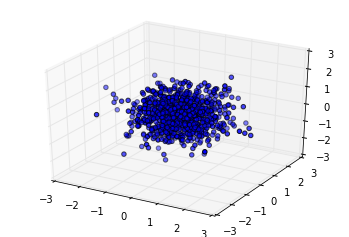

In [22]:
#Note that for the actual ground state we should plot the walker position multilied with the guidance function
plot_position(Pos_walkers,alive)